# Final project: Time-series data and application to stock markets {-}

This project aims at familiarizing you with time-series data analysis and its application to stock markets. Datasets you will be working on are Nasdaq and Vietnam stock datasets.

### Submission {-}
The structure of submission folder should be organized as follows:

- ./\<StudentID>-project-notebook.ipynb: Jupyter notebook containing source code.
- ./\<StudentID>-project-report.pdf: project report.

The submission folder is named DL4AI-\<StudentID>-project (e.g., DL4AI-2012345-project) and then compressed with the same name.
    
### Evaluation {-}
Project evaluation will be conducted on how you accomplish the assignment requirements. You can refer to the project instruction slide deck for details.

### Deadline {-}
Please visit Canvas for details.

In [1]:
# Load libraries
import os
import pandas as pd
import numpy as np
import time 
import glob
import pickle
from datetime import datetime

In [2]:
path = '../DL4AI-200011-project/data/data-vn-20230228/'

In [3]:
vn_csv = glob.glob(os.path.join(path+'stock-historical-data/', "*.csv"))
print('VN:',len(vn_csv))

VN: 1629


In [4]:
# Get some info about the data
pd.read_csv(vn_csv[0]).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2968 entries, 0 to 2967
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   2968 non-null   int64  
 1   Open         2968 non-null   float64
 2   High         2968 non-null   float64
 3   Low          2968 non-null   float64
 4   Close        2968 non-null   float64
 5   Volume       2968 non-null   int64  
 6   TradingDate  2968 non-null   object 
dtypes: float64(4), int64(2), object(1)
memory usage: 162.4+ KB


## Choose Companies

### Choose companies based on top companies in VNINDEX

In [5]:
# Get companies in top 100 VNINDEX
vn_index = pd.read_html('https://topforeignstocks.com/indices/the-components-of-the-vietnam-vn-index/')[0]
vn_index = vn_index.iloc[:100]
print(vn_index.shape)
vn_index[['Ticker']].head(n=3)

(100, 3)


,Ticker
0,AAV
1,ACM
2,ADC


In [6]:
#get company and its sector
sector = pd.read_csv(path+'ticker-overview.csv')
sector = sector[['ticker', 'industryEn']]
sector.head(n=3)

,ticker,industryEn
0,VVS,Automobiles & Parts
1,XDC,Construction & Materials
2,HSV,Basic Resources


To have a good prediction, need to get historical data at least 3-5 years -> choose 2017



In [7]:
# get nearest day of dataset
from datetime import datetime
symbol = [] #get list of choosen companies
for company in os.listdir(path+'stock-historical-data/'):
    name = company.split('-')[0]
    if name in vn_index['Ticker'].values and name != 'LRCX':
        data = pd.read_csv(path+'stock-historical-data/'+company)
        date = data['TradingDate'].values[0]
        #filter data by established date
        if int(date.split('-')[-1]) <= 2002:
            symbol.append(name)
#pd.DataFrame(symbol).to_csv(path+'stock_symbols.csv', index=False, header = None)
print('Number of choosen companies:', len(symbol))


Number of choosen companies: 99


### Group companies by sector

In [8]:
# group by sector
selected_com = sector[sector['ticker'].isin(symbol)]
selected_com = selected_com[['ticker', 'industryEn']].reset_index(drop=True)
#keep first name of stock
selected_com['industryEn'].replace(' ','_', regex=True, inplace=True)
# adj list of company and sector
adj_list = {}
for i in range(len(selected_com)):
    if adj_list.get(selected_com['industryEn'][i]) is None:
        adj_list[selected_com['industryEn'][i]] = [selected_com['ticker'][i]]
    else:
        adj_list[selected_com['industryEn'][i]].append(selected_com['ticker'][i])

#save group company by sector
with open(path+'symbols.pkl', 'wb') as fp:
    pickle.dump(adj_list, fp)

In [9]:
print(adj_list)

{'Real_Estate': ['AAV', 'API', 'BII', 'CEO', 'D11', 'FID'], 'Basic_Resources': ['ACM', 'AMC', 'BKC', 'CAP', 'DPS', 'HGM', 'HHP', 'CLM'], 'Media': ['ADC', 'ALT', 'BDB', 'BED', 'BST', 'DAD', 'DAE', 'DST', 'EBS', 'ECI', 'EID', 'HEV'], 'Industrial_Goods_&_Services': ['CAG', 'AME', 'ARM', 'BBS', 'BPC', 'BXH', 'CJC', 'CIA', 'CTB', 'CTT', 'DHP', 'DL1', 'DPC', 'DXP', 'DZM', 'GMA', 'GIC', 'HCT', 'DS3'], 'Health_Care': ['AMV', 'CVN', 'DNM', 'DP3'], 'Chemicals': ['APP', 'CPC'], 'Financial_Services': ['APS', 'BVS', 'ART', 'HBS', 'EVS'], 'Travel_&_Leisure': ['ATS', 'CTC', 'HHG'], 'Food_&_Beverage': ['BNA', 'BLF', 'CAN', 'CTP', 'HAD', 'HAT', 'HHC', 'HKB', 'HKT', 'BCF'], 'Construction_&_Materials': ['BCC', 'BTS', 'C69', 'C92', 'CMS', 'CSC', 'CTX', 'CX8', 'DC2', 'DIH', 'DNP', 'DVG', 'GMX', 'HCC', 'HDA', 'GKM', 'DTD', 'BAX', 'CLH'], 'Retail': ['BSC', 'DHT'], 'Utilities': ['BTW', 'DNC', 'GDW', 'HJS', 'DDG'], 'Technology': ['CKV'], 'Automobiles_&_Parts': ['CMC'], 'Personal_&_Household_Goods': ['GLT', 'CE

## Filter company by establish times and sector

In [10]:
# define some parameters
roll_window = 30 #rolling window size for simple moving average
window_size = 30 #history window size, based on which we predict next T days
delta_T =  10 # predict next T days

X_label = []
y_label = []
for i in range(window_size):
    X_label.append('CloseT'+str(-i-1))
for i in range(delta_T):
    y_label.append('CloseT+'+str(i+1))

X_label = X_label + ['Close']

with open(path+'symbols.pkl', 'rb') as fp:
    symbols = pickle.load(fp)

In [11]:
#save adj list of company and sector
if not os.path.exists(path+'filtered_data/'):
    os.makedirs(path+'filtered_data/')
for sector in symbols:
    if not os.path.exists(path+'filtered_data/'+sector+'/'):
        os.makedirs(path+'filtered_data/'+sector+'/')
    for company in adj_list[sector]:
        for i in vn_csv:
            if company in i:
                data = pd.read_csv(i)
                data = data[['Open', 'High', 'Low', 'Close', 'Volume', 'TradingDate']]
                data.columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Date']
                break
        #add label for each company
        for i in range(window_size):
            data['CloseT'+str(-i-1)] = (data['Close'].shift(i+1)-data['Close'])/data['Close']
        for i in range(delta_T):
            data['CloseT+'+str(i+1)] = (data['Close'].shift(-i-1)-data['Close'])/data['Close']
        data = data.dropna().reset_index(drop = True)
        data.to_csv(path+'filtered_data/'+sector+'/'+company+'.csv', index=False)

In [12]:
pd.read_csv(path+'filtered_data/Retail/'+symbols['Retail'][0]+'.csv').head(n=3)

,Open,High,Low,Close,Volume,Date,CloseT-1,CloseT-2,CloseT-3,CloseT-4,...,CloseT+1,CloseT+2,CloseT+3,CloseT+4,CloseT+5,CloseT+6,CloseT+7,CloseT+8,CloseT+9,CloseT+10
0,5858.0,5916.0,5858.0,5916.0,200,2011-02-24,-0.038878,-0.029074,-0.029074,0.038878,...,0.058316,0.058316,0.058316,0.009635,0.029074,0.077586,0.077586,0.106829,0.106829,0.067951
1,6261.0,6261.0,6203.0,6261.0,300,2011-02-25,-0.055103,-0.091838,-0.082575,-0.082575,...,0.000000,0.000000,-0.045999,-0.027631,0.018208,0.018208,0.045839,0.045839,0.009104,-0.055103
2,6261.0,6261.0,6261.0,6261.0,1000,2011-02-28,0.000000,-0.055103,-0.091838,-0.082575,...,0.000000,-0.045999,-0.027631,0.018208,0.018208,0.045839,0.045839,0.009104,-0.055103,-0.055103


## Build model

In [13]:
# Import libraries
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv1D, Dense, LSTM, Dropout
from keras.optimizers import Adam
from keras import initializers, metrics
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

2023-05-31 10:24:52.410788: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
class Model(tf.keras.Model):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = Conv1D(filters=32, kernel_size=3, activation='relu', padding='same', input_shape=(window_size, 1))
        self.lstm1 = LSTM(window_size, return_sequences=True)
        self.lstm2 = LSTM(window_size)
        self.dropout = Dropout(0.2)
        self.dense1 = Dense(window_size, activation='tanh')
        self.dense2 = Dense(delta_T, activation='tanh')
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.lstm1(x)
        x = self.dropout(x)
        x = self.lstm2(x)
        x = self.dense1(x)
        x = self.dropout(x)
        x = self.dense2(x)
        return x

In [15]:
#load data from filtered data
X_data = {}
y_data = {}
sector = glob.glob(os.path.join(path+'filtered_data/', "*"))
for sec in sector:
    companies = glob.glob(os.path.join(sec+'/', "*.csv"))
    if sec.split('/')[-1] not in X_data:
        X_data[sec.split('/')[-1]] = {}
        y_data[sec.split('/')[-1]] = {}
    for company in companies:
        name = company.split('/')[-1].split('.')[0]
        X_data[sec.split('/')[-1]][name] = pd.read_csv(company)[X_label]
        y_data[sec.split('/')[-1]][name] = pd.read_csv(company)[y_label]

print(X_data['Retail']['BSC'].columns[:5])
print(y_data['Retail']['BSC'].columns[:5])

Index(['CloseT-1', 'CloseT-2', 'CloseT-3', 'CloseT-4', 'CloseT-5'], dtype='object')
Index(['CloseT+1', 'CloseT+2', 'CloseT+3', 'CloseT+4', 'CloseT+5'], dtype='object')


Because of positive correlation between each companies in same sector, so we build each prediction model for each sector

Sector model can learn from all companies in sector's companies

In [16]:
if not os.path.exists(path+'model/'):
    os.makedirs(path+'model/')
for sec in symbols:
    # get sector, each model is trained for each sector
    print('Training sector', sec.split('/')[-1])
    model = Model()
    if  os.path.exists(path+'model/'+sec.split('/')[-1]):
        model.load_weights(path+'model/'+sec.split('/')[-1])

    model.compile(optimizer= Adam(learning_rate=0.001, decay = 0.01), loss='mse')
    callback = EarlyStopping(monitor='val_loss', patience=10)
    #checkout
    checkout_path = path+'model/'+sec.split('/')[-1]+'/model.ckpt'
    checkout = ModelCheckpoint(checkout_path, save_best_only=True, save_weights_only=True,verbose=0)
    X_train_sec, y_train_sec, X_val_sec, y_val_sec, X_test_sec, y_test_sec = [], [], [], [], [], []
    print('Get company: ') 
    for company in X_data[sec.split('/')[-1]]:
        print(company, end=' ')
        val_size = 0.1
        test_size = 300 #days
        X = np.array(X_data[sec.split('/')[-1]][company].values)
        y = np.array(y_data[sec.split('/')[-1]][company].values)
        X_train = X[:-test_size]
        y_train = y[:-test_size]
        X_test = X[-test_size:]
        y_test = y[-test_size:]
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size, shuffle=False)


        #reshape data
        X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
        y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], 1)
        X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
        y_val = y_val.reshape(y_val.shape[0], y_val.shape[1], 1)
        X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
        y_test = y_test.reshape(y_test.shape[0], y_test.shape[1], 1)

        #concat to X_train_sec, y_train_sec, X_val_sec, y_val_sec, X_test_sec, y_test_sec
        X_train_sec = np.concatenate((X_train_sec, X_train), axis=0) if len(X_train_sec) != 0 else X_train
        y_train_sec = np.concatenate((y_train_sec, y_train), axis=0) if len(y_train_sec) != 0 else y_train
        X_val_sec = np.concatenate((X_val_sec, X_val), axis=0) if len(X_val_sec) != 0 else X_val
        y_val_sec = np.concatenate((y_val_sec, y_val), axis=0) if len(y_val_sec) != 0 else y_val
        X_test_sec = np.concatenate((X_test_sec, X_test), axis=0) if len(X_test_sec) != 0 else X_test
        y_test_sec = np.concatenate((y_test_sec, y_test), axis=0) if len(y_test_sec) != 0 else y_test
        
    #shuffle data
    X_train_sec, y_train_sec = shuffle(X_train_sec, y_train_sec)
    
    #train model
    model.fit(X_train_sec, y_train_sec, epochs=100, batch_size=2048, validation_data=(X_val_sec, y_val_sec), callbacks=[callback, checkout], verbose=0)
    
    #evaluate model
    model.evaluate(X_test_sec, y_test_sec)

    print('Finish training sector', sec.split('/')[-1])
    print('--------------------------------------')

Training sector Real_Estate


2023-05-31 10:24:58.421793: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-31 10:24:58.438040: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-31 10:24:58.438275: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-31 10:24:58.439318: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operation

Get company: 
FID CEO BII API D11 AAV 

2023-05-31 10:25:01.154668: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401


57/57 [==============================] - 0s 2ms/step - loss: 0.0202
Finish training sector Real_Estate
--------------------------------------
Training sector Basic_Resources
Get company: 
75/75 [==============================] - 0s 2ms/step - loss: 0.0084
Finish training sector Basic_Resources
--------------------------------------
Training sector Media
Get company: 
113/113 [==============================] - 0s 2ms/step - loss: 0.0080
Finish training sector Media
--------------------------------------
Training sector Industrial_Goods_&_Services
Get company: 
179/179 [==============================] - 0s 2ms/step - loss: 0.0052
Finish training sector Industrial_Goods_&_Services
--------------------------------------
Training sector Health_Care
Get company: 
38/38 [==============================] - 0s 2ms/step - loss: 0.0074
Finish training sector Health_Care
--------------------------------------
Training sector Chemicals
Get company: 
19/19 [==============================] - 0s 3ms/st

## Buy and Sell point

Find optimal way to maximum profit

In [17]:
def max_profit(prices, threshold):
    n = len(prices)
    if n < 2:
        return 0, [], []

    selling_date = 0
    buying_date = 0
    total_profit = 0
    buy_times = []
    sell_times = []

    for i in range(1, len(prices)):
        if prices[i] >= prices[i - 1]:
            selling_date += 1
        else:
            profit = prices[selling_date] - prices[buying_date]
            if profit > threshold:
                total_profit += profit
                buy_times.append(buying_date)
                sell_times.append(selling_date)
            selling_date = buying_date = i

    profit = prices[selling_date] - prices[buying_date]
    if profit > threshold:
        total_profit += profit
        buy_times.append(buying_date)
        sell_times.append(selling_date)

    return total_profit, buy_times, sell_times


1/1 [==============================] - 1s 706ms/step
real profit: -500.0
expected profit: 1029.2080078125


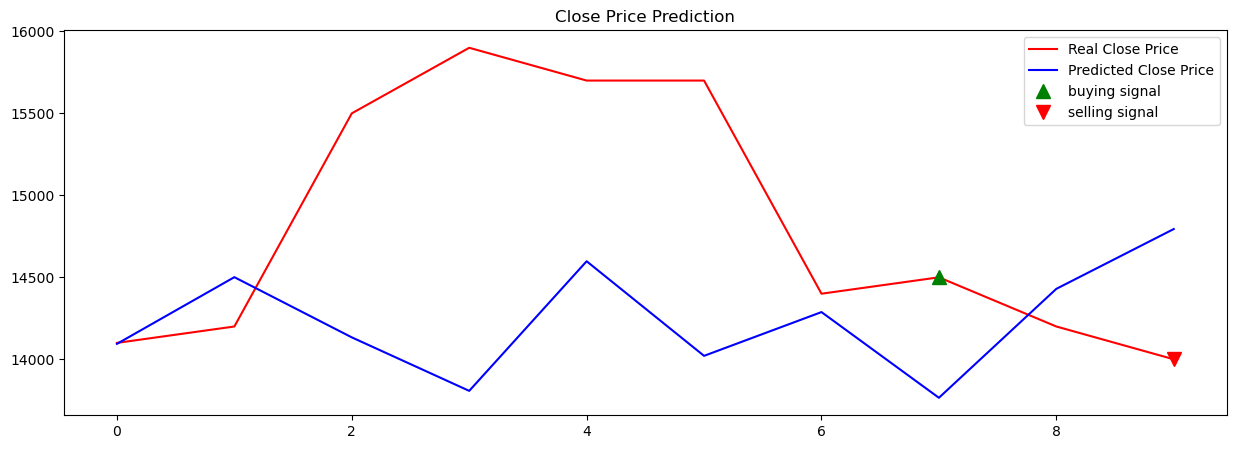

In [18]:
# test our algorithm

import matplotlib.pyplot as plt
#test buy sell
load_model = Model()
load_model.load_weights(path+'model/Industrial_Goods_&_Services/model.ckpt')
load_data = pd.read_csv(path+'filtered_data/Industrial_Goods_&_Services/AME.csv')

date_trade = datetime(2022, 1, 10)
load_data['Date'] = pd.to_datetime(load_data['Date'])
x_data  = load_data[load_data['Date'] <= date_trade][-window_size-1:]
y_data = load_data[load_data['Date'] > date_trade][:delta_T]

today_price = x_data.iloc[-1]['Close']
x_data  = x_data['Close'].values
y_data = y_data['Close'].values
#normalize data
x_data = (x_data - today_price)/today_price

x_data = x_data.reshape(1, x_data.shape[0], 1)
pred_data = load_model.predict(x_data)[0]
pred_data = pred_data*today_price + today_price

fig = plt.figure(figsize = (15,5))
profit, buy, sell = max_profit(pred_data, threshold = 1000)
real_profit = 0
for i in range(len(buy)):
    real_profit += y_data[sell[i]] - y_data[buy[i]]

print('real profit:', real_profit)    
print('expected profit:', profit)

plt.plot(y_data, color='red', label = 'Real Close Price')
plt.plot(pred_data, color='blue', label = 'Predicted Close Price')
plt.plot(y_data, '^', markersize=10, color='g', label = 'buying signal', markevery = buy)
plt.plot(y_data, 'v', markersize=10, color='r', label = 'selling signal', markevery = sell)
plt.title('Close Price Prediction')
plt.legend()
plt.show()


## Portfolio Management

Trading by our model, and find the top expected profit

In [19]:
path = '../DL4AI-200011-project/data/data-vn-20230228/'
window_size = 30 #history window size
delta_T =  10 # predict next T days
threshold = 0.1 # threshold for buying and selling
future_day = []
trade_date = datetime(2021, 8, 3)

vn_csv = glob.glob(os.path.join(path+'stock-historical-data/', "*.csv"))

# Trade stock by our model
def trading(now, path, threshold, window_size = 30, delta_T = 10):
    date = pd.read_csv(path+'stock-historical-data/A32-UpcomIndex-History.csv')
    date['TradingDate'] = pd.to_datetime(date['TradingDate'], format='%Y-%m-%d')
    date = list(date[date['TradingDate'] > now]['TradingDate'].values[:delta_T])
    date = [str(i).split('T')[0][5:] for i in date]
    trade_table = pd.DataFrame(columns = ['Company', 'Sector','Profit']+ date)

    with open(path+'symbols.pkl', 'rb') as fp:
        symbols = pickle.load(fp)
    for sec in symbols:
        model = Model()
        model.load_weights(path+'model/'+sec+'/model.ckpt')
        for company in symbols[sec]:
            for i in vn_csv:
                if company in i:
                    data = pd.read_csv(i)
                    data = data[['Open', 'High', 'Low', 'Close', 'Volume', 'TradingDate']]
                    data.columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Date']
                    break

            data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')
            x_data  = data[data['Date'] <= now][-window_size-1:]

            today_price = x_data.iloc[-1]['Close']
            x_data  = x_data['Close'].values

            #normalize data
            x_data = (x_data - today_price)/today_price
            x_data = x_data.reshape(1, x_data.shape[0], 1)

            pred = model.predict(x_data)[0]
            pred = pred*today_price + today_price
            
            profit, buy_times, sell_times = max_profit(pred, threshold)
            if profit == 0:
                continue
            pred_table = {}
            pred_table['Company'] = company
            pred_table['Sector'] = sec
            pred_table['Profit'] = profit
            
            for i in range(len(pred)):
                if i in buy_times:
                    pred_table[date[i]] = 'buy'
                elif i in sell_times:
                    pred_table[date[i]] = 'sell'
                else:
                    pred_table[date[i]] = ' '
            trade_table = pd.concat([trade_table, pd.DataFrame(pred_table, index = [0], columns=['Company', 'Sector','Profit']+ date)])
            sort_table = trade_table.sort_values(by=['Profit'], ascending=False)
    return sort_table

trade_table = trading(now = trade_date, path = path, threshold = threshold, window_size = window_size, delta_T = delta_T)
trade_table.to_csv(path+'trade_table.csv', index=False)

1/1 [==============================] - 0s 12ms/step


## Display top companies in portfolio

In [20]:
trade_table = pd.read_csv(path+'trade_table.csv')
print('top 10 profitable companies')
trade_table.head(10)

top 10 profitable companies


,Company,Sector,Profit,08-04,08-05,08-06,08-09,08-10,08-11,08-12,08-13,08-16,08-17
0,HHC,Food_&_Beverage,15168.156250,,buy,,sell,,buy,sell,buy,,sell
1,GMA,Industrial_Goods_&_Services,8655.707031,buy,sell,,buy,sell,buy,sell,buy,,sell
2,ARM,Industrial_Goods_&_Services,8101.960938,buy,sell,,buy,sell,buy,sell,buy,,sell
3,CAP,Basic_Resources,7947.656250,buy,sell,buy,sell,,buy,sell,buy,sell,
4,CAN,Food_&_Beverage,7293.437500,,buy,,sell,,buy,sell,buy,,sell
5,CSC,Construction_&_Materials,7284.980469,buy,sell,buy,,,sell,,buy,sell,
6,DP3,Health_Care,7203.078125,buy,sell,,,buy,,,sell,,
7,BAX,Construction_&_Materials,6969.394531,buy,,sell,buy,,sell,,buy,sell,
8,BCF,Food_&_Beverage,6625.613281,,buy,,sell,,buy,sell,buy,,sell
9,HGM,Basic_Resources,5980.519531,buy,sell,buy,sell,,buy,sell,buy,sell,


In [21]:
print('top 10 loss companies')
trade_table.tail(10)

top 10 loss companies


,Company,Sector,Profit,08-04,08-05,08-06,08-09,08-10,08-11,08-12,08-13,08-16,08-17
89,ACM,Basic_Resources,442.176270,buy,sell,buy,sell,,buy,sell,buy,sell,
90,BDB,Media,431.782227,,buy,sell,buy,,sell,,buy,sell,
91,EBS,Media,399.958984,,buy,sell,buy,,sell,,buy,sell,
92,API,Real_Estate,382.037598,,,,buy,sell,buy,,,sell,
93,CTC,Travel_&_Leisure,375.314941,,,buy,,sell,,buy,,sell,
94,HHG,Travel_&_Leisure,313.924316,,,buy,,sell,,buy,,sell,
95,HKB,Food_&_Beverage,261.550903,,buy,,sell,,buy,sell,buy,,sell
96,DST,Media,175.180908,,buy,sell,buy,,sell,,buy,sell,
97,DPS,Basic_Resources,172.244995,buy,sell,buy,,sell,buy,sell,buy,sell,
98,FID,Real_Estate,156.511719,,,,buy,sell,buy,,,sell,


## Build App

In [22]:
!streamlit run ../DL4AI-200011-project/stock_trading_app.py


  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://192.168.0.194:8501

2023-05-31 10:26:51.733446: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-31 10:26:53.152520: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-31 10:26:53.171174: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-31 10:26:53.171452: I tensorflow